# Auto Encoder를 이용한 잡음제거

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
# 데이터 로드
(X_train,y_train), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
# 타입, 범위 변경
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

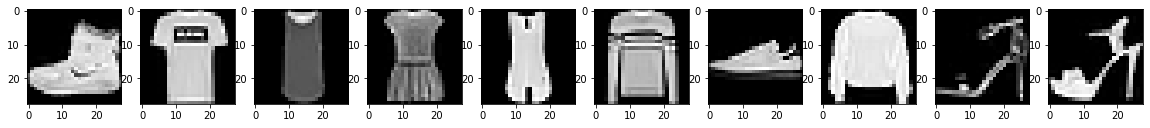

In [ ]:
# 시각화
n = 10
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.gray()

# 잡음이 없음

In [ ]:
# 잡음 생성
print(X_train[0].shape)

# 같은 줄칸을 더해야함
X_train0_nosie0 = X_train[0] + tf.random.normal(shape=(28, 28))

# 노이즈 양 조절
X_train_nosiy0 = X_train[0] + 0.2 * tf.random.normal(shape=(28, 28))

(28, 28)


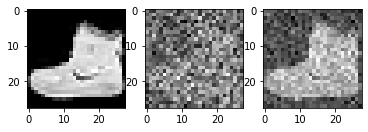

In [ ]:
plt.subplots(1,3)

plt.subplot(1, 3, 1)
plt.imshow(X_train[0])

plt.subplot(1, 3, 2)
plt.imshow(X_train0_nosie0)

plt.subplot(1, 3, 3)
plt.imshow(X_train_nosiy0)

In [ ]:
X_train_nosiy = tf.reshape(X_train, shape = (-1 , 28, 28, 1))
X_train_nosiy =  X_train_nosiy + 0.2 * tf.random.normal(shape=(60000,28,28,1))

# 이미지 범위 0~1사이
# clip_value_min = 0 : 0보다 작은 놈은 0
# clip_value_min = 1 : 1보다 큰 놈은 1
X_train_nosiy = tf.clip_by_value(X_train_nosiy, clip_value_max =1, clip_value_min = 0)


# X_test 잡음 추가
X_test_noisy = tf.reshape(X_test, shape = (-1 , 28, 28, 1))
X_test_noisy =  X_test_noisy + 0.2 * tf.random.normal(shape=(10000,28,28,1))

# 이미지 범위 0~1사이
# clip_value_min = 0 : 0보다 작은 놈은 0
# clip_value_min = 1 : 1보다 큰 놈은 1
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_max =1, clip_value_min = 0)

In [ ]:
encoder = Sequential([
                      Conv2D(filters = 16,
                             kernel_size = 3,
                             activation = 'relu',
                             padding = 'SAME',
                             strides =2,
                             input_shape= (28, 28,1)
                             ),
                      Conv2D(filters = 8,
                             kernel_size = 3,
                             activation = 'relu',
                             padding = 'SAME',
                             strides = 2)
])

In [ ]:
encoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder = Sequential([
                      Conv2DTranspose(filters = 8,
                                      kernel_size = 3,
                                      strides =2,
                                      activation = 'relu',
                                      padding = 'SAME',
                                      input_shape =(7, 7, 8)
                                      ),
                      Conv2DTranspose(filters = 16,
                                      kernel_size = 3,
                                      strides =2,
                                      activation = 'relu',
                                      padding = 'SAME',
                                      input_shape =(7, 7, 8)
                                        ),
                      Conv2D(1, kernel_size = 3, activation = 'sigmoid', padding = 'SAME')
])

In [ ]:
class AutoEncoder(Model):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
auto_encoder = AutoEncoder(encoder, decoder)

In [ ]:
auto_encoder.compile(optimizer = Adam(learning_rate =0.001),
                                      loss = MeanSquaredError())

In [ ]:
auto_encoder.fit(X_train_nosiy, X_train, epochs =30,
                 validation_data =(X_test_noisy, X_test))

Epoch 1/30
1875/1875 [==============================] - 21s 3ms/step - loss: 0.0186 - val_loss: 0.0103
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 5/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 8/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 9/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 10/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.00

In [ ]:
# X_test를 인코더를 이용해서 64개의 데이터로 압축
encoded_imgs = auto_encoder.encoder(X_test_noisy).numpy()

In [ ]:
# 압축한 데이터를 원래 이미지로 복구
decoded_imgs = auto_encoder.decoder(encoded_imgs).numpy()

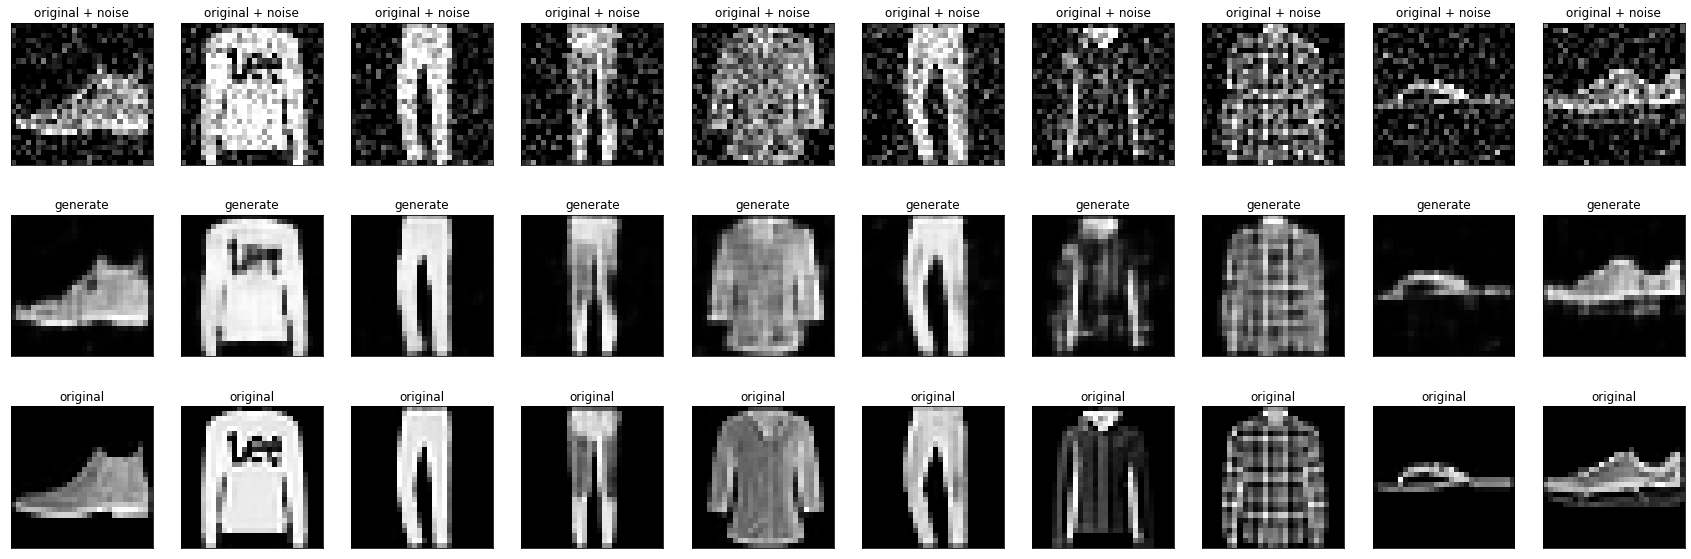

In [ ]:
n = 10
# 그래프의 가로 세로 설정
plt.figure(figsize=(30, 10))
#10번 반복
for i in range(n):
  # 3줄 10칸중에 i+1번째 이미지 출력 준비
  ax = plt.subplot(3, n, i + 1)
  plt.title("original + noise")
  # 테스트 이미지 출력
  #tf.squeeze : 3차원인 X_test[i] 를 2차원으로 차원 축소
  plt.imshow(tf.squeeze(X_test_noisy[i]))
  # 흑백으로 줄력
  plt.gray()
  #x축 좌표가 출력되지 않도록 설정
  ax.get_xaxis().set_visible(False)
  #y축 좌표가 출력되지 않도록 설정
  ax.get_yaxis().set_visible(False)

  # 3줄 10칸중에 i+1 + n(10) 번째 이미지 출력 준비
  ax = plt.subplot(3, n, i + 1 + n)
  plt.title("generate")
  # 생성 이미지 출력
  #tf.squeeze : 3차원인 decoded_imgs[i] 를 2차원으로 차원 축소
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  # 흑백으로 줄력
  plt.gray()
  #x축 좌표가 출력되지 않도록 설정
  ax.get_xaxis().set_visible(False)
  #y축 좌표가 출력되지 않도록 설정
  ax.get_yaxis().set_visible(False)

  # 3줄 10칸중에 i+1 + n*2(10) 번째 이미지 출력 준비
  ax = plt.subplot(3, n, i + 1 + n*2)
  plt.title("original")
  # 잡음이 없는 원본 이미지 출력
  #tf.squeeze : 3차원인 X_test[i] 를 2차원으로 차원 축소
  plt.imshow(tf.squeeze(X_test[i]))
  # 흑백으로 줄력
  plt.gray()
  #x축 좌표가 출력되지 않도록 설정
  ax.get_xaxis().set_visible(False)
  #y축 좌표가 출력되지 않도록 설정
  ax.get_yaxis().set_visible(False)